### Explore the data

Tasks 
<ul>
    <li> Clearning, imputing missing values</li>
    <li> Correlation analysis, correspondace analysis</li>
    <li> Plots</li>
<ul>



In [142]:
import pandas as pd 
import numpy as np
import seaborn as sns

%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from mpl_toolkits.axisartist.grid_helper_curvelinear import \
    GridHelperCurveLinear

plt.rcParams["figure.figsize"] = (15, 10)


In [198]:
df = pd.read_csv(r'data\data.csv', header=0)

In [26]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,31/10/2000,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,31/10/2000,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,31/10/2000,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,31/10/2000,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,31/10/2000,LAL @ POR,POR,5


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

The 5000 missing data on shot_made_flag are left out for testing purpose. We should consider separating those

In [199]:
test = df[df['shot_made_flag'].isnull()]
df = df.loc[df.index.difference(test.index)]

#### Plot of shots made and missed

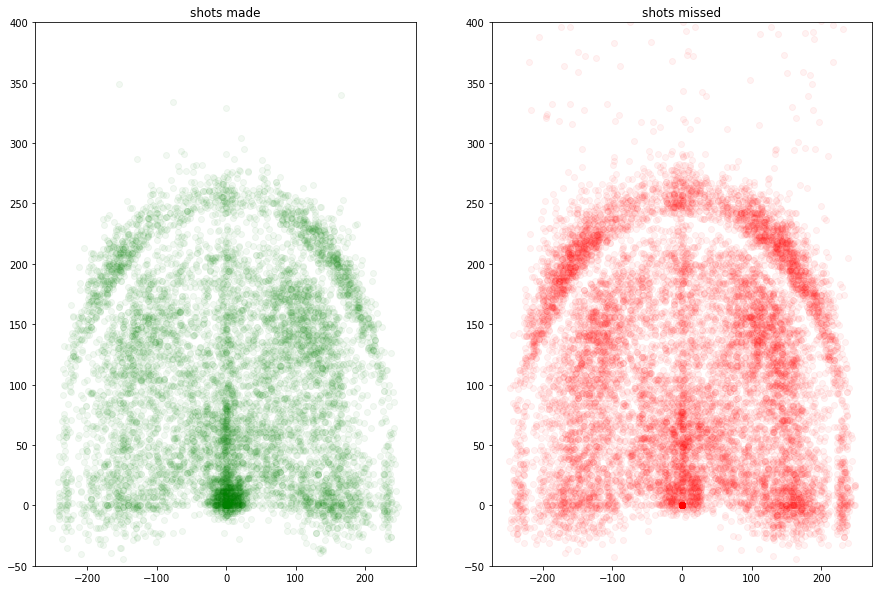

In [29]:
alpha = .05

plt.subplot(121)
made = df[df['shot_made_flag']==1]
plt.scatter(made['loc_x'], made['loc_y'], c='green', alpha=alpha)
plt.ylim([-50, 400])
plt.title('shots made')

plt.subplot(122)
miss = df[df['shot_made_flag']==0]
plt.scatter(miss['loc_x'], miss['loc_y'], c='red', alpha=alpha)
plt.ylim([-50, 400])
plt.title('shots missed')


plt.show()

He seems to prefer shots that are either directly inline with the basket, or at a ~25 degree angle from it. he also misses a lot when he's under the basket/ on the right side of the basket when angle=0. That could be a flag.

#### shot zone vs accuracy

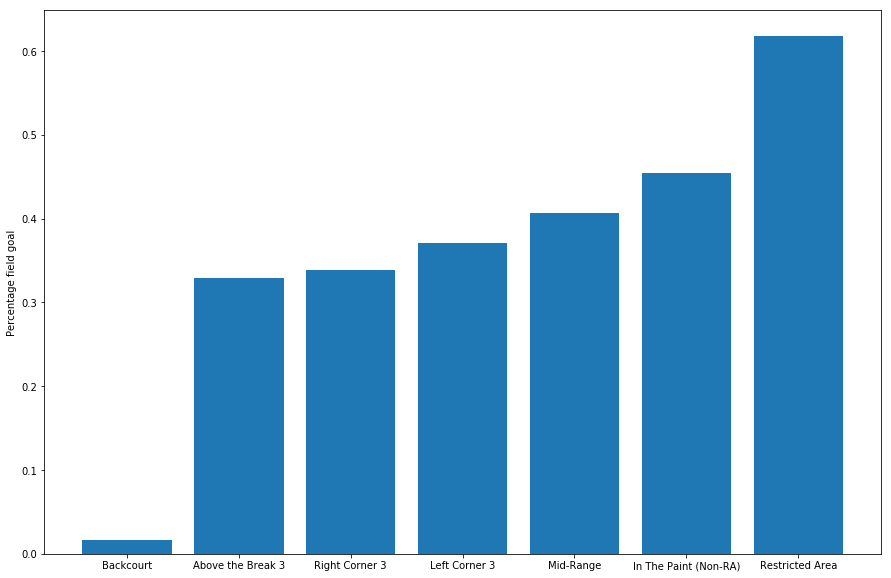

In [30]:
acc_zone = df.groupby('shot_zone_basic').mean()['shot_made_flag'].sort_values()
plt.bar(range(7), acc_zone)
plt.xticks(range(7), acc_zone.index)
plt.ylabel('Percentage field goal')
plt.show()

#### Calculate distance, angle from the basket using x and y coordinates

In [31]:
df['distance'] = np.sqrt(df['loc_x']**2 + df['loc_y']**2)
df['distance_bin_30'], distance_bins = pd.cut(df['distance'], bins=30, retbins=True, include_lowest=True)

# calculate the angle using radians, measuring from the x axis
# since law of reflection says the incident angle is the same as angle of reflection,
# it's more likely that Kobe would consider the incident angle instead of the polar angle when 
# he taks a shot, we need to convert that. The normal vector to the backboard is at radians pi/2
# however, doing so would destroy the assymetricity of the problem. So we add a sign to it 
df['angle'] = np.arctan(df['loc_y']/df['loc_x']).fillna(0) + np.pi/2
df['angle_bin_30'], angle_bins = pd.cut(df['angle'], bins=30, retbins=True, right=True, include_lowest=True)


# doing the above assumes symmetricit across the normal vector pointing out from the basket, we must add back the 
# side of the basket he's in. We do this by simply 

df['side'] = np.sign(np.pi/2 - df['angle'])

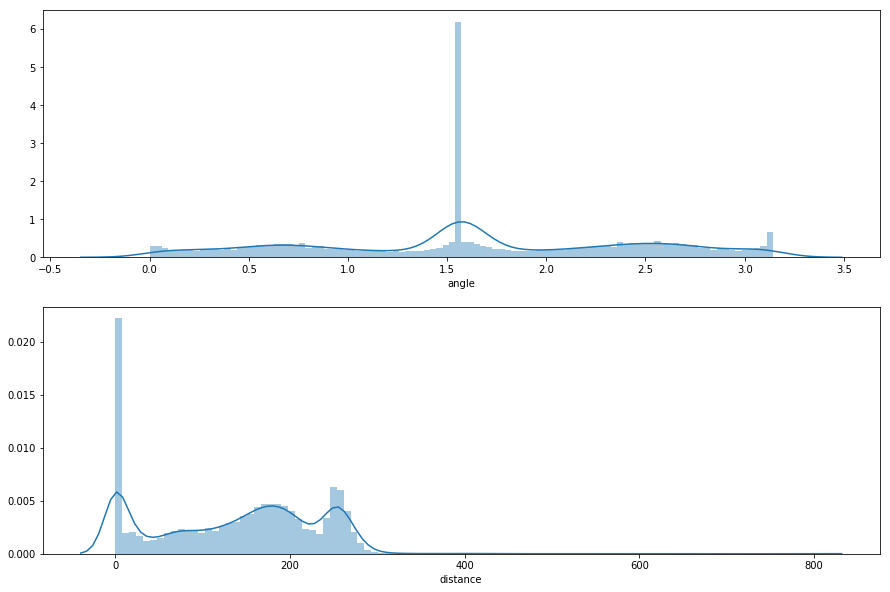

In [32]:
plt.subplot(211)
sns.distplot(df['angle'], bins=100)

plt.subplot(212)
sns.distplot(df['distance'], bins=100)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

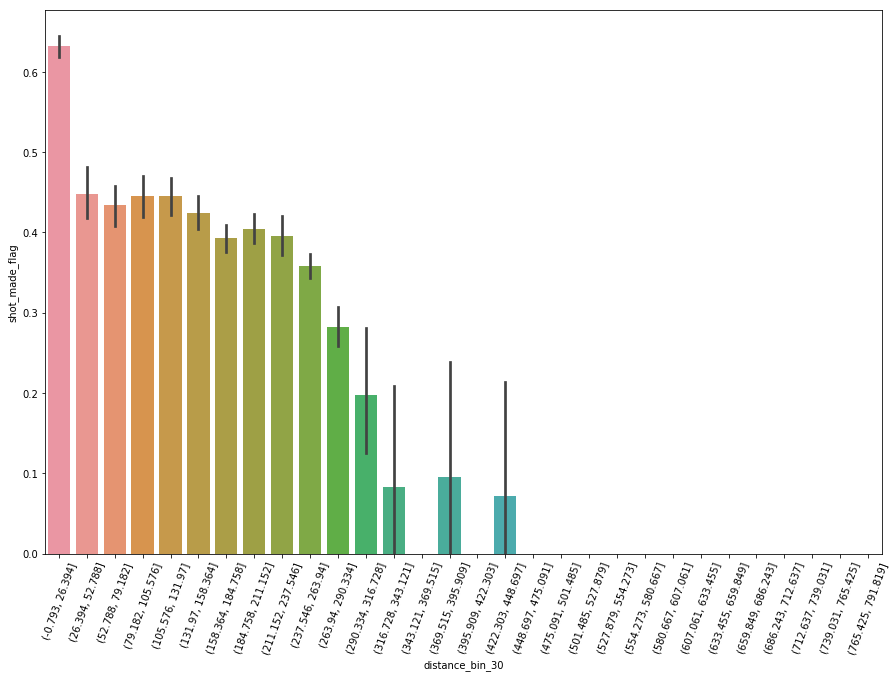

In [33]:
sns.barplot(x='distance_bin_30', y='shot_made_flag', data=df)
plt.xticks(rotation=70)

What are the relationships between these variables and the shots that he's made?

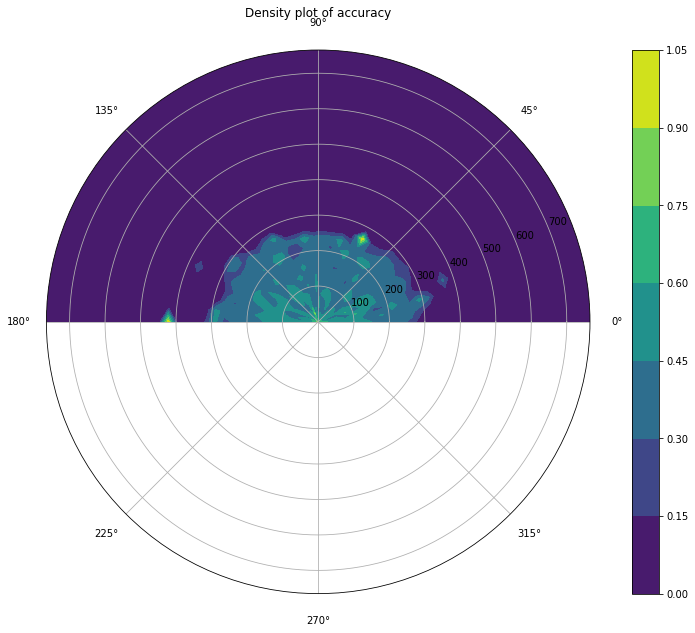

In [34]:
polar_acc = df.groupby(['distance_bin_30', 'angle_bin_30']).mean()['shot_made_flag'].unstack().fillna(0)

fig = plt.figure()

ax = fig.add_subplot(111, polar=True)
ctf = ax.contourf(np.linspace(0, np.pi, 30), distance_bins[:-1], polar_acc)
ax.set_title('Density plot of accuracy')
plt.colorbar(ctf)
ax.set_xlim(0, 180)

#### Psychological factors

Stuff like time remaining, period, playoffs etc...

minutes_remaining is the minutes remaining in that quater and seconds remaining is the seconds reamining in that minute. Combining them we see the tota time termaining in the quater.


In [35]:
df['overtime'] = (df['period'] > 4).astype(int)

df['period_time_remaining'] = df['minutes_remaining'] * 60 + df['seconds_remaining']
# 20 seconds cuts
df['period_time_remaining_bin'] = pd.cut(df['period_time_remaining'], bins=np.linspace(0, 720, 72))

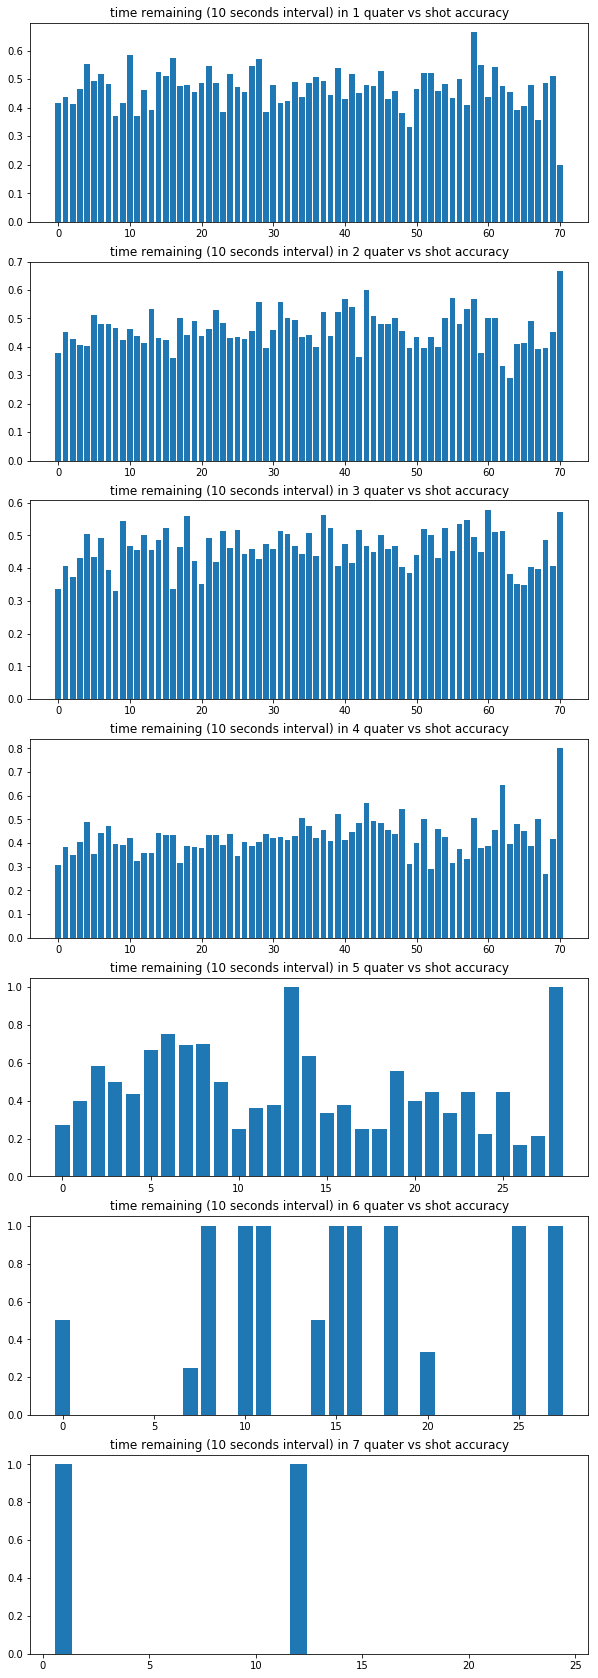

In [36]:
period_time_acc = df.groupby(['period_time_remaining_bin', 'period']).mean()['shot_made_flag'].unstack()

plt.figure(figsize=(10, 30))
for period in range(1, 8):
    plt.subplot(7, 1, period)
    plt.bar(range(71), period_time_acc.loc[:, period])
    plt.title('time remaining (10 seconds interval) in {} quater vs shot accuracy'.format(period))
    

(0.3, 0.5)

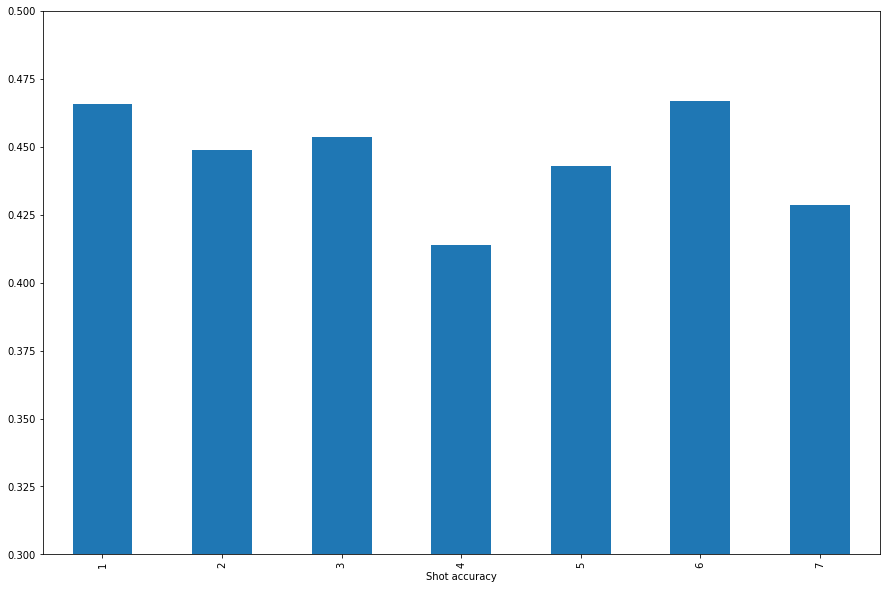

In [37]:
df.groupby('period').mean()['shot_made_flag'].plot(kind='bar')
plt.xlabel('Shot accuracy')
plt.ylim(0.3, 0.5)

A drop in accuracy during the forth quater! Which could be accredited to the tighter defences or overall fatique

In [38]:
# cummulative number of shots taken per game

df['cum_shot_attempts_game'] = df.groupby('game_id').cumcount()

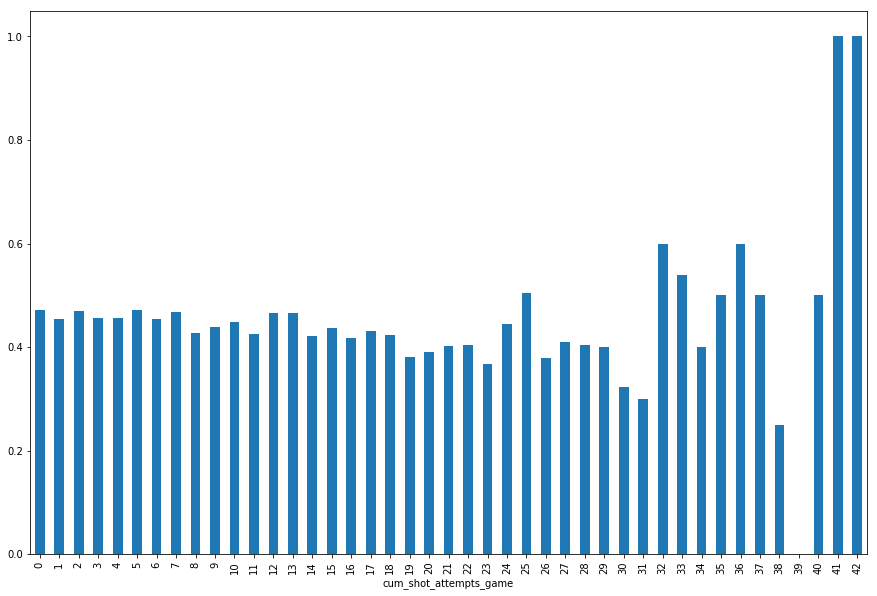

In [39]:
df.groupby('cum_shot_attempts_game').mean()['shot_made_flag'].plot(kind='bar')

it's evident that his accuracy decreases as he take more and more shots. This is due to fatique reasons and tighter defences around him. If we can prove that Kobe doesn't have a hot hand effect, it then begs the question, should he have passed the ball?

#### Outcome of the last shot 

In [40]:
df['last_shot_made'] = df.groupby('game_id')['shot_made_flag'].shift(1)

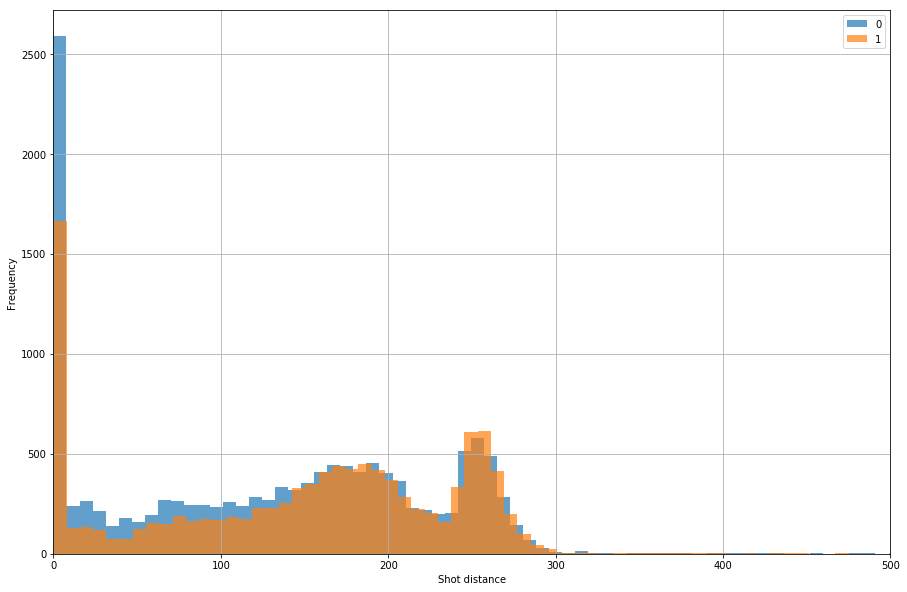

In [41]:
df[df['last_shot_made']==0]['distance'].hist(bins=100, label='0', alpha=.7)
df[df['last_shot_made']==1]['distance'].hist(bins=100, label='1', alpha=.7)
plt.xlabel('Shot distance')
plt.ylabel('Frequency')
plt.xlim((0, 500))
plt.legend()

When kobe misses a shot, he falls to the safety regions around 0-100 away from the basket. Where his accuracy stands above 40 percent. When he made a shot, he moves further away from his "safe zone" and attempts harder shots atj around 250

#### Missing streak? Shooting spree?

How about when he misses 2 shots in a row? 3? 4?..

In [42]:
def streaks(df, col):
    sign = np.sign(df[col]-.5)
    s = sign.groupby((sign!=sign.shift()).cumsum()).cumsum()
    return df.assign(made_streak=s.where(s>0, 0.0), miss_streak=s.where(s<=0, 0.0).abs())

gp = df.groupby('game_id')
new_df = pd.DataFrame()

for g in gp.groups:
    new_df = new_df.append(streaks(gp.get_group(g), 'shot_made_flag')[['made_streak', 'miss_streak']])

In [43]:
df = pd.concat([df, new_df], axis=1)

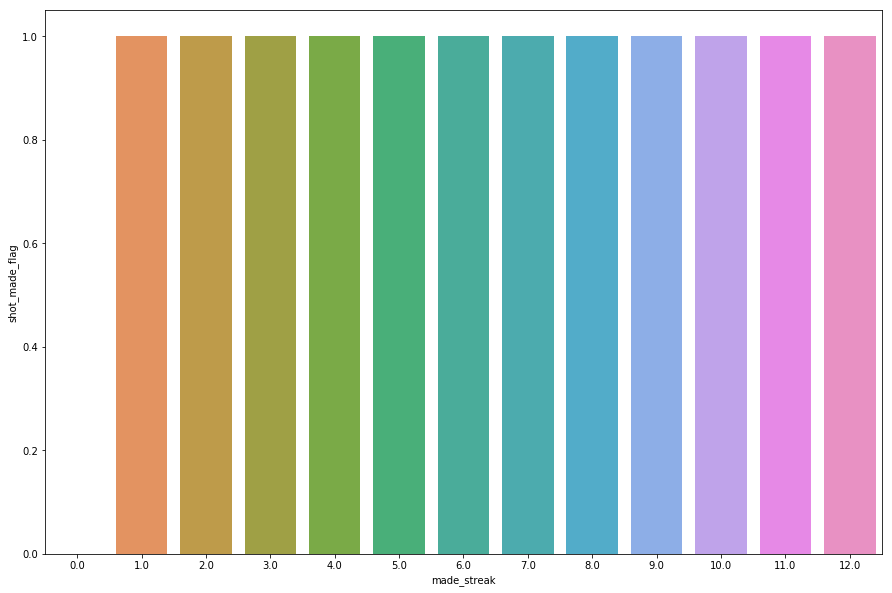

In [44]:
sns.barplot(x='made_streak', y='shot_made_flag', data=df)

### Possible features to use

- Rolling lagged average shots made per quater.
- Distance of shot away from "hot zone" (zone where his shot made percentages is the highest)
- Rolling lagged average of shots made against each team.
- A quantized difficulty of the shot he's making. (distance, type, 2pt, 3pt, time remaining)
- 手感 Is he "feeling it" before the shot? (stuff like field goal percentage in that game)
- Laker's winning streak 
- Laker's losing streak

In [57]:
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

In [205]:
not_used_columns = ['game_event_id', 'game_id', 'lat', 'lon', 
                    'team_id', 'team_name', 'game_date', 
                    'matchup', 'shot_id', 'action_type', 'shot_made_flag']
baseline_df = df.drop(not_used_columns, axis=1)
test_df = test.drop(not_used_columns, axis=1)

In [206]:
cat_feat = baseline_df.columns[baseline_df.dtypes=='object']

In [207]:
# one hot the categorical variables

from sklearn.base import TransformerMixin
class MultitargetLabelEncoder(TransformerMixin):
    """
    Fit a label encoder per column
    """

    def __init__(self, cols=None):
        self.cols = cols
        self.lab_enc = {col: LabelEncoder() for col in cols}

    def fit(self, df):
        for col in self.cols:
            self.lab_enc[col].fit(df[col])

        return self

    def transform(self, df):
        df = df.copy()
        for col in self.cols:
            df[col] = self.lab_enc[col].transform(df[col])
        
        return df

    def fit_transform(self, df):
        df = df.copy()
        for col in self.cols:
            df[col] = self.lab_enc[col].fit_transform(df[col])

        return df
    
le = MultitargetLabelEncoder(cols=cat_feat)
le_feat = le.fit_transform(baseline_df)
le_test = le.transform(test_df)



oe = OneHotEncoder(categorical_features=np.where(baseline_df.dtypes=='object'))
oe_feat = oe.fit_transform(le_feat)
oe_test = oe.transform(le_test)



# oe = OneHotEncoder()
# oe_feat = oe.fit_transform(le_feat)

# action_type = pd.get_dummies(baseline_df['action_type'])
# combined_shot_type = pd.get_dummies(baseline_df['combined_shot_type'])
# baseline_df['season'] = baseline_df['season'].factorize()[0]
# baseline_df['shot_type'] = baseline_df['shot_type'].factorize()[0]
# area = pd.get_dummies(baseline_df['shot_zone_area'])
# opponent = pd.get_dummies(baseline_df['opponent'])

# baseline_df = pd.concat([baseline_df, area, action_type, combined_shot_type, opponent], axis=1)

# baseline_df.drop(['action_type', 'combined_shot_type', 'opponent',
#                  'shot_zone_area', 'shot_zone_basic', 'shot_zone_range'], axis=1, inplace=True)

In [110]:
baseline_df = pd.concat([baseline_df, area, action_type, combined_shot_type, opponent], axis=1)

In [111]:
baseline_df.drop(['action_type', 'combined_shot_type', 'opponent',
                 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range'], axis=1, inplace=True)

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [212]:
X = oe_feat
y = df['shot_made_flag']

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [214]:
rf = RandomForestClassifier(n_estimators=20, 
                           criterion='entropy',
                           max_depth=5)

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [116]:
from sklearn.metrics import *

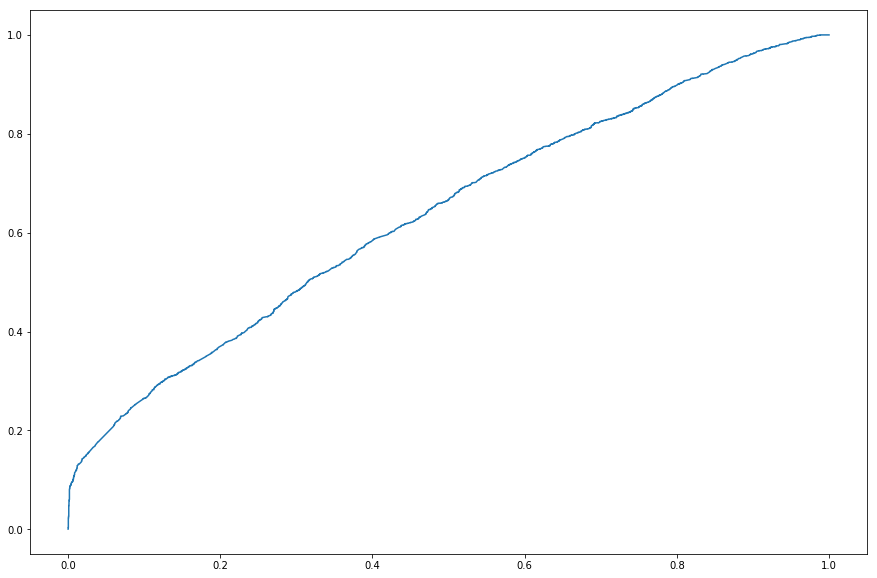

In [216]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

Submitting to kaggle

In [217]:
prediction = rf.predict_proba(oe_test)[:, 1]

In [223]:
submission = pd.DataFrame(prediction, index=test['shot_id']).reset_index()

In [224]:
submission.to_csv('submission.csv', index=None)